Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
# plt.plot([1])
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sax
import logging
import sys
from functools import partial
from pprint import pprint
import gdsfactory as gf
import jax.example_libraries.optimizers as opt
from gdsfactory.generic_tech import get_generic_pdk
from numpy.fft import fft2, fftfreq, fftshift, ifft2
from rich.logging import RichHandler
from scipy import constants
from sklearn.linear_model import LinearRegression
from tqdm.notebook import trange
import gplugins.sax as gs
import gplugins.tidy3d as gt
from gplugins.common.config import PATH
from math import e

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

logger = logging.getLogger()
logger.removeHandler(sys.stderr)
logging.basicConfig(level="WARNING", datefmt="[%X]", handlers=[RichHandler()])

gf.config.set_plot_options(show_subports=False)


2024-05-08 18:43:59.111 | INFO     | gplugins.tidy3d:<module>:61 - Tidy3d '2.4.3' installed at ['c:\\Users\\oaper\\anaconda3\\Lib\\site-packages\\tidy3d']
2024-05-08 18:43:59.258 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: 'c:\\Users\\oaper\\anaconda3\\Lib\\site-packages\\gdsfactory\\generic_tech\\layer_views.yaml'.
2024-05-08 18:43:59.261 | INFO     | gdsfactory.pdk:activate:307 - 'generic' PDK is now active


MZI circuit 

In [2]:
parameter_array = [10, 2, 2]


def straight(wl=1.5, length=10.0, neff=2.4) -> sax.SDict:
    return sax.reciprocal({("o1", "o2"): jnp.exp(2j * jnp.pi * neff * length / wl)})

def mmi1x2():
    """Assumes a perfect 1x2 splitter"""
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.5**0.5,
            ("o1", "o3"): 0.5**0.5,
        }
    )

def bend_euler(wl=1.5, length=20.0):
    """ "Let's assume a reduced transmission for the euler bend compared to a straight"""
    return {k: 0.99 * v for k, v in straight(wl=wl, length=length).items()}

def bend_euler_2(wl=1.5, length=20.0):
    """ "Let's assume a reduced transmission for the euler bend compared to a straight"""
    return {k: 0.98 * v for k, v in straight(wl=wl, length=length).items()}

def waveguide(wl=1.55, wl0=1.55, neff=2.34, ng=3.4, length=10.0, loss=0.0) -> sax.SDict:
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    return sax.reciprocal(
        {
            ("o1", "o2"): transmission,
        }
    )

models = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": straight,

}

models_2 = {
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
    "straight": waveguide,
}

mzi_component = gf.components.mzi(
    delta_length=parameter_array[0], length_x=parameter_array[2], length_y=parameter_array[1],
)
        
mzi_circuit, _ = sax.circuit(
    netlist=mzi_component.get_netlist(),
    models=models,
)

mzi_circuit_2, _ = sax.circuit(
    netlist=mzi_component.get_netlist(),
    models=models_2,
)
S = mzi_circuit(
    wl=1.53,
    syl={
        "length": parameter_array[0] / 2 + 2,
    },
    straight_9={
        "length": parameter_array[0] / 2 + 2,
    },
)


Loss Function Definition - for minima at target wavelength

For an initially set constant parameter (delta_length), and for a target wavelength, run optimization.

In [3]:

@jax.jit
def loss_fn(delta_length, opt_wl):
    wl_ = opt_wl
    S = mzi_circuit_2(
        wl=wl_,
        syl={
            "length": delta_length / 2 + 2,
        },
        straight_9={
            "length": delta_length / 2 + 2,
        },
    )
    return (abs(S["o1", "o2"]) ** 2).mean()

grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

def step_fn(step, state, opt_wl):
    settings = params_fn(state)
    # print(settings)
    loss = loss_fn(settings, opt_wl)
    grad = grad_fn(settings, opt_wl)
    state = update_fn(step, grad, state)
    return loss, state

range_ = trange(300)
for step in range_:
    loss, state = step_fn(step, state, 1.53)
    range_.set_postfix(loss=f"{loss:.6f}")

delta_length = params_fn(state)
print(delta_length)

  0%|          | 0/300 [00:00<?, ?it/s]

30.22716684746296


Sweep target wavelength

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

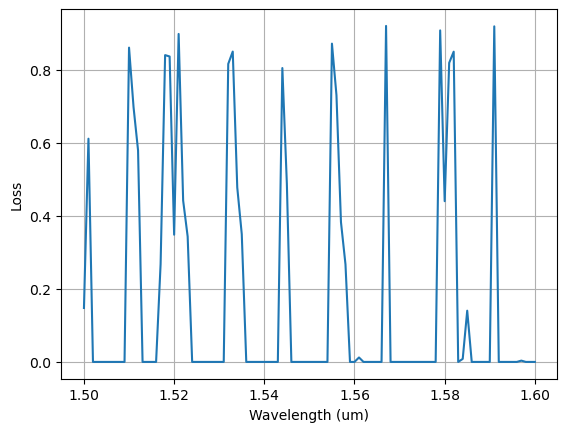

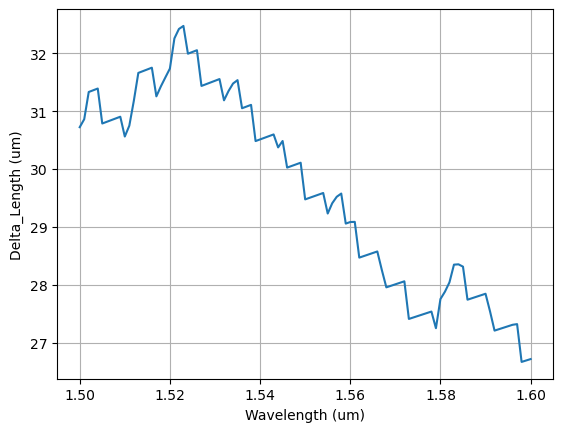

In [4]:
wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array = []
delta_length_array = []

for opt_wl in wavelength_array:
    range_ = trange(300)
    for step in range_:
        loss, state = step_fn(step, state, opt_wl)
        range_.set_postfix(loss=f"{loss:.6f}")
    final_loss_array = final_loss_array + [loss]
    delta_length_array = delta_length_array + [params_fn(state)]

plt.figure()
plt.plot(wavelength_array, final_loss_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()

The success of the optimizer is strongly related to initial conditions, and at certain wavelengths, we are widely away from our target. 

What are the options? 
*   Optimizer parameters(step_size, b1, b2) [*]
*   Other optimizers (adagrad, and others) [**]

[*] https://jax.readthedocs.io/en/latest/jax.example_libraries.optimizers.html#jax.example_libraries.optimizers.adam

[**] https://jax.readthedocs.io/en/latest/jax.example_libraries.optimizers.html#jax.example_libraries.optimizers.adagrad

  0%|          | 0/300 [00:00<?, ?it/s]

30.478129602540754


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

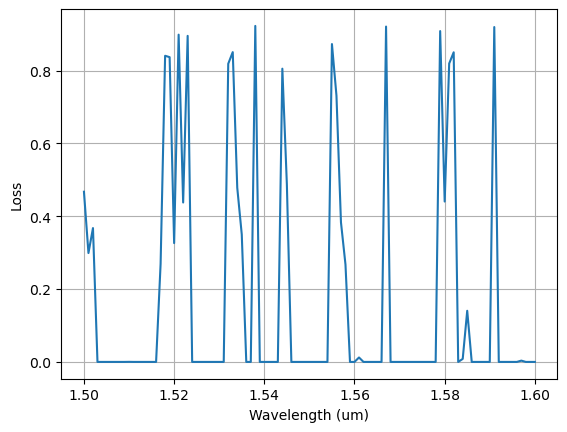

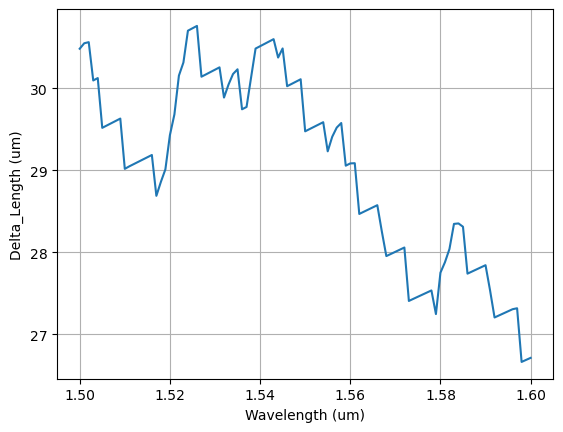

In [5]:

@jax.jit
def loss_fn(delta_length, opt_wl):
    wl_ = opt_wl
    S = mzi_circuit_2(
        wl=wl_,
        syl={
            "length": delta_length / 2 + 2,
        },
        straight_9={
            "length": delta_length / 2 + 2,
        },
    )
    return (abs(S["o1", "o2"]) ** 2).mean()

grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1, b1=0.95, b2=0.999)
state = init_fn(initial_delta_length)

def step_fn(step, state, opt_wl):
    settings = params_fn(state)
    # print(settings)
    loss = loss_fn(settings, opt_wl)
    grad = grad_fn(settings, opt_wl)
    state = update_fn(step, grad, state)
    return loss, state

range_ = trange(300)
for step in range_:
    loss, state = step_fn(step, state, 1.58)
    range_.set_postfix(loss=f"{loss:.6f}")

delta_length = params_fn(state)
print(delta_length)

wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array = []
delta_length_array = []

for opt_wl in wavelength_array:
    range_ = trange(300)
    for step in range_:
        loss, state = step_fn(step, state, opt_wl)
        range_.set_postfix(loss=f"{loss:.6f}")
    final_loss_array = final_loss_array + [loss]
    delta_length_array = delta_length_array + [params_fn(state)]

plt.figure()
plt.plot(wavelength_array, final_loss_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()

  0%|          | 0/1000 [00:00<?, ?it/s]

30.229200181449144


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

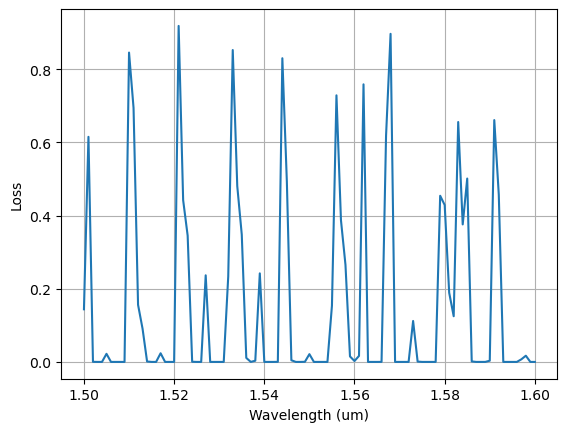

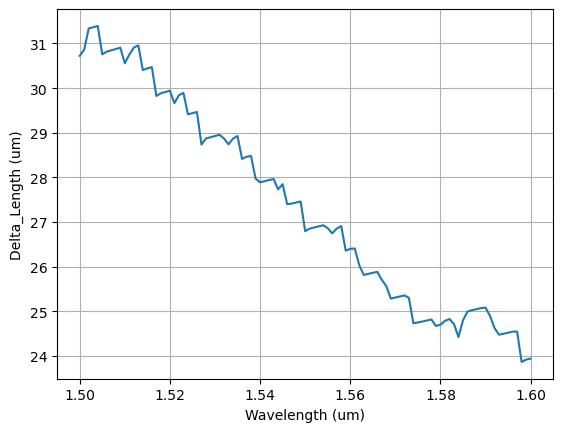

In [6]:

@jax.jit
def loss_fn(delta_length, opt_wl):
    wl_ = opt_wl
    S = mzi_circuit_2(
        wl=wl_,
        syl={
            "length": delta_length / 2 + 2,
        },
        straight_9={
            "length": delta_length / 2 + 2,
        },
    )
    return (abs(S["o1", "o2"]) ** 2).mean()

grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

initial_delta_length = 30.0
# init_fn, update_fn, params_fn = opt.adam(step_size=0.1, b1=0.7, b2=0.7)
init_fn, update_fn, params_fn = opt.adagrad(step_size=0.1, momentum=0.99)
state = init_fn(initial_delta_length)

def step_fn(step, state, opt_wl):
    settings = params_fn(state)
    # print(settings)
    loss = loss_fn(settings, opt_wl)
    grad = grad_fn(settings, opt_wl)
    state = update_fn(step, grad, state)
    return loss, state

range_ = trange(1000)
for step in range_:
    loss, state = step_fn(step, state, 1.53)
    range_.set_postfix(loss=f"{loss:.6f}")

delta_length = params_fn(state)
print(delta_length)

wavelength_array = np.linspace(1.5, 1.6, 101)
final_loss_array = []
delta_length_array = []

for opt_wl in wavelength_array:
    range_ = trange(1000)
    for step in range_:
        loss, state = step_fn(step, state, opt_wl)
        range_.set_postfix(loss=f"{loss:.6f}")
    final_loss_array = final_loss_array + [loss]
    delta_length_array = delta_length_array + [params_fn(state)]

plt.figure()
plt.plot(wavelength_array, final_loss_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()


Update (08.05.2024): 

Let's run a certain peak wavelength of loss function individually (instead of sweep) to see if there is a problem in parameter update in loop (this may be a similar problem with the later seen particle warm sweep problem). 

(1.55, 1.56)

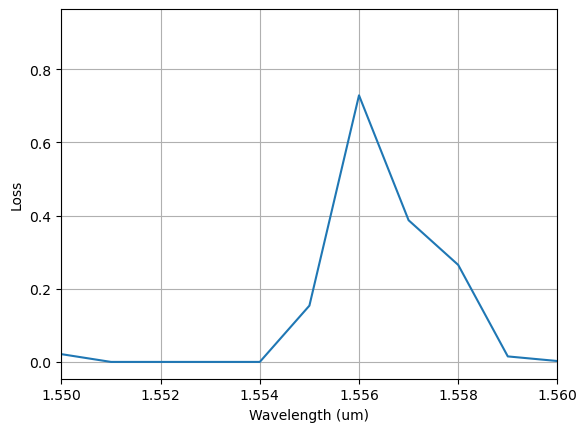

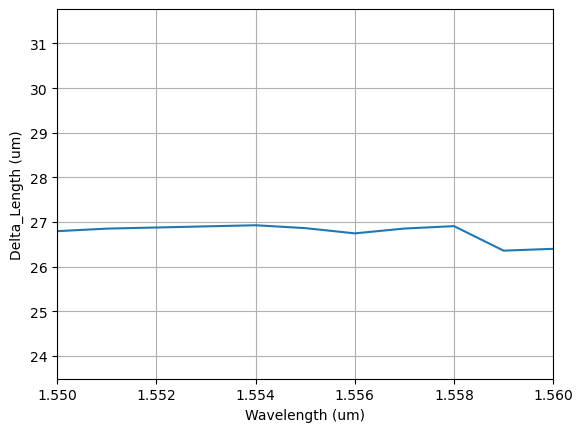

In [7]:
plt.figure()
plt.plot(wavelength_array, final_loss_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()
plt.xlim([1.55, 1.56])

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()
plt.xlim([1.55, 1.56])

Loss peak at 1.556 um. Let's run optimization code.  

In [8]:
initial_delta_length = 30.0
init_fn, update_fn, params_fn = opt.adagrad(step_size=0.1, momentum=0.99)
state = init_fn(initial_delta_length)

def step_fn(step, state, opt_wl):
    settings = params_fn(state)
    # print(settings)
    loss = loss_fn(settings, opt_wl)
    grad = grad_fn(settings, opt_wl)
    state = update_fn(step, grad, state)
    return loss, state

range_ = trange(1000)
for step in range_:
    loss, state = step_fn(step, state, 1.556)
    range_.set_postfix(loss=f"{loss:.6f}")

delta_length = params_fn(state)
print(delta_length)

  0%|          | 0/1000 [00:00<?, ?it/s]

29.40965642326539


Loss is similarly bad, but optimized value is different. 

Another option is use of particle swarm optimization

In [9]:
# Import modules
import numpy as np
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO

global opt_wl

a = 1.5
opt_wl= a
@jax.jit
def loss_fn(delta_length):
    wl_ = opt_wl
    S = mzi_circuit_2(
        wl=wl_,
        syl={
            "length": delta_length / 2 + 2,
        },
        straight_9={
            "length": delta_length / 2 + 2,
        },
    )
    return (abs(S["o1", "o2"]) ** 2).mean()



%time
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.9, 'w':0.7}

# Call instance of PSO
bounds=([29], [31])

optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=1, options=options, bounds=bounds)

# Perform optimization
cost, pos = optimizer.optimize(loss_fn, iters=1000)



2024-05-08 18:48:36,800 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}


CPU times: total: 0 ns
Wall time: 0 ns


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:48:41,078 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]


Wavelength sweep - currently problematic

2024-05-08 18:48:41,104 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:48:45,019 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:48:45,026 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:48:48,913 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:48:48,920 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:48:52,790 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:48:52,797 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:48:56,686 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:48:56,692 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:49:00,554 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:49:00,561 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:49:04,386 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:49:04,392 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:49:08,521 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:49:08,527 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:49:12,337 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:49:12,343 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:49:16,197 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:49:16,206 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:49:20,119 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:49:20,125 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:49:24,002 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:49:24,009 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:49:27,855 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:49:27,862 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:49:31,971 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:49:31,979 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:49:35,864 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:49:35,870 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:49:39,721 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:49:39,728 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:49:43,623 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:49:43,630 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:49:47,518 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:49:47,525 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0843
2024-05-08 18:49:51,388 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08426198488735287, best pos: [29.29049031]
2024-05-08 18:49:51,395 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0385
2024-05-08 18:49:55,488 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.03854580839759744, best pos: [29.29049031]
2024-05-08 18:49:55,495 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00434
2024-05-08 18:49:59,321 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0043366223802307965, best pos: [29.29049031]
2024-05-08 18:49:59,331 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:03,197 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:03,204 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:07,038 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:07,045 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:10,910 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:10,917 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:14,767 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:14,774 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:18,884 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:18,890 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:22,768 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:22,775 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:26,680 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:26,686 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:30,551 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:30,560 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:34,403 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:34,410 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:38,269 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:38,275 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:42,423 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:42,429 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:46,277 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:46,284 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:50,120 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:50,126 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:53,983 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:53,990 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:50:57,820 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:50:57,826 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:51:01,624 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:51:01,631 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:51:05,698 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:51:05,704 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:51:09,548 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:51:09,554 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:51:13,352 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:51:13,359 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:51:17,162 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:51:17,169 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:51:21,032 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:51:21,050 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:51:24,875 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:51:24,881 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.00414
2024-05-08 18:51:28,983 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004141177254332454, best pos: [29.29049031]
2024-05-08 18:51:28,990 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:51:32,888 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:51:32,895 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:51:36,715 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:51:36,722 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:51:40,534 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:51:40,543 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:51:44,362 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:51:44,368 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:51:48,187 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:51:48,195 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:51:52,298 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:51:52,305 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:51:56,126 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:51:56,133 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:51:59,955 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:51:59,962 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:03,830 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:03,836 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:07,670 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:07,677 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:11,512 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:11,519 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:15,613 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:15,619 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:19,466 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:19,472 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:23,298 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:23,305 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:27,159 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:27,165 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:31,063 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:31,070 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:34,910 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:34,916 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:38,756 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:38,763 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:42,934 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:42,941 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:46,833 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:46,840 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:50,727 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:50,733 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:54,611 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:54,617 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:52:58,478 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:52:58,485 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000511
2024-05-08 18:53:02,463 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.000511212150373358, best pos: [29.29049031]
2024-05-08 18:53:02,471 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:53:06,631 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:53:06,638 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:53:10,533 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:53:10,540 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:53:14,415 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:53:14,422 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:53:18,310 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:53:18,316 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:53:22,275 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:53:22,282 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:53:26,286 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:53:26,294 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:53:30,452 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:53:30,459 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:53:34,387 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:53:34,394 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:53:38,338 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:53:38,344 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:53:42,276 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:53:42,283 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:53:46,204 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:53:46,211 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:53:50,191 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:53:50,198 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:53:54,478 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:53:54,485 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:53:58,446 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:53:58,453 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:02,423 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:02,430 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:06,399 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:06,407 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:10,367 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:10,374 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:14,355 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:14,362 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:18,604 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:18,611 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:22,633 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:22,639 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:26,640 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:26,647 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:30,690 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:30,697 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:34,728 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:34,735 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:38,820 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:38,826 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:42,880 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:42,887 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:47,181 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:47,188 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:51,235 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:51,243 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:55,386 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:55,393 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:54:59,474 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:54:59,480 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:55:03,635 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:55:03,644 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:55:07,756 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:55:07,764 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:55:12,063 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:55:12,070 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/1000

Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:55:16,138 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]


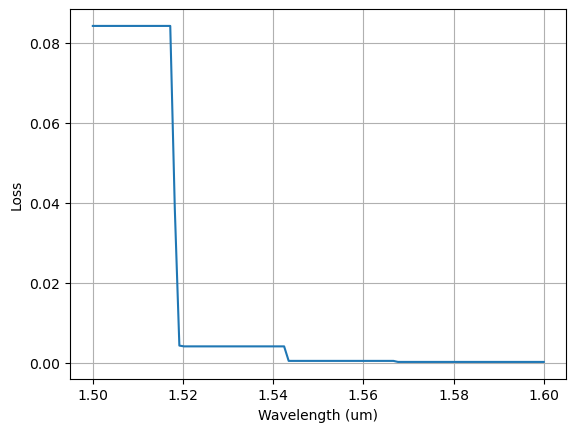

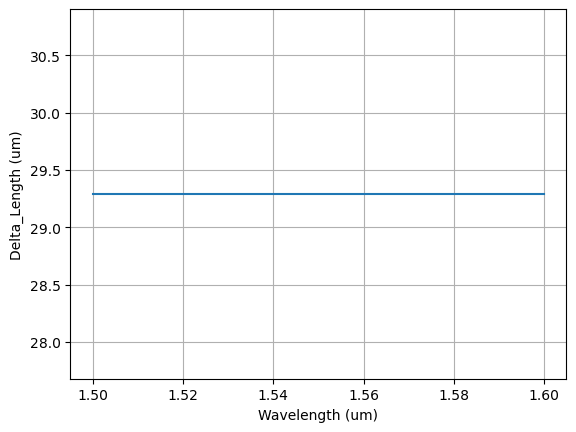

In [10]:
wavelength_array = np.linspace(1.5, 1.6, 100)
final_loss_array = []
delta_length_array = []

for opt_wl_ in wavelength_array:
    
    @jax.jit
    def loss_fn(delta_length, opt_wl):
        wl = opt_wl
        S = mzi_circuit_2(
            wl=wl,
            syl={
                "length": delta_length / 2 + 2,
        },
            straight_9={
                "length": delta_length / 2 + 2,
            },
        )
        print(wl)
        return (abs(S["o1", "o2"]) ** 2).mean()
    cost, pos = optimizer.optimize(lambda delta_length: loss_fn(delta_length, opt_wl_), iters=1000)
    final_loss_array = final_loss_array + [cost]
    delta_length_array = delta_length_array + [pos]

plt.figure()
plt.plot(wavelength_array, final_loss_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()


2024-05-08 18:55:16,519 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.000254
2024-05-08 18:55:17,873 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:55:17,875 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.000254
2024-05-08 18:55:18,189 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:55:18,191 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.000254
2024-05-08 18:55:18,499 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051

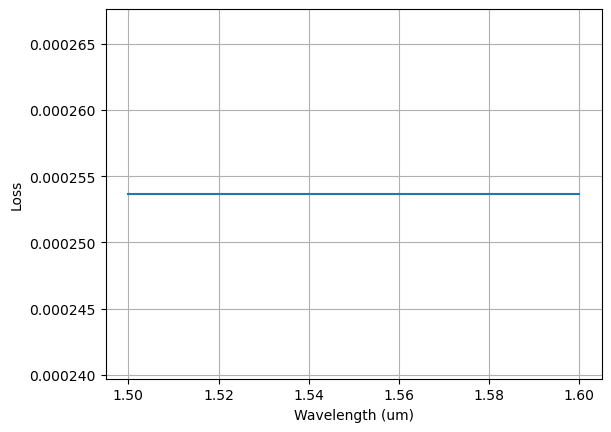

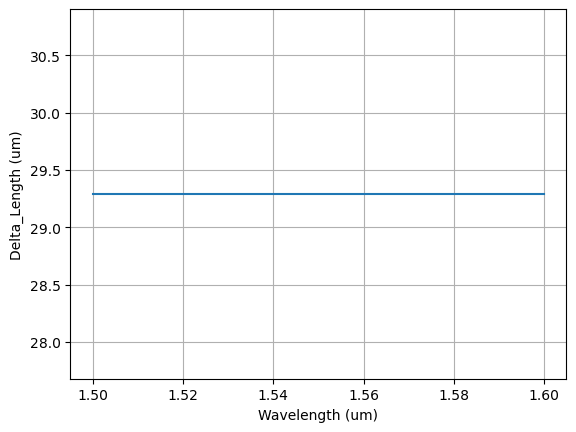

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# Assuming mzi_circuit_2 and optimizer are defined elsewhere
    
@jax.jit
def loss_fn(delta_length, opt_wl_=1.6):
    opt_wl__= opt_wl_
    S = mzi_circuit(
        wl=opt_wl__,
        syl={"length": delta_length / 2 + 2},
        straight_9={"length": delta_length / 2 + 2},
    )
    return (abs(S["o1", "o2"]) ** 2).mean()

# Arrays
wavelength_array = np.linspace(1.5, 1.6, 3)
final_loss_array = []
delta_length_array = []

for opt_wl_ in wavelength_array:
    cost, pos = optimizer.optimize(lambda dl: loss_fn(dl, opt_wl_), iters=100)
    final_loss_array.append(cost)
    delta_length_array.append(pos)

# Plotting
plt.figure()
plt.plot(wavelength_array, final_loss_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()


2024-05-08 18:55:18,886 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:55:22,882 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:55:22,883 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:55:26,903 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591089711051, best pos: [29.29049031]
2024-05-08 18:55:26,904 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000254
2024-05-08 18:55:30,846 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0002536591

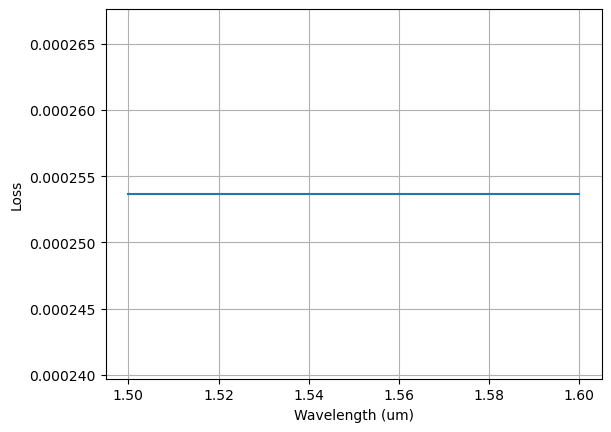

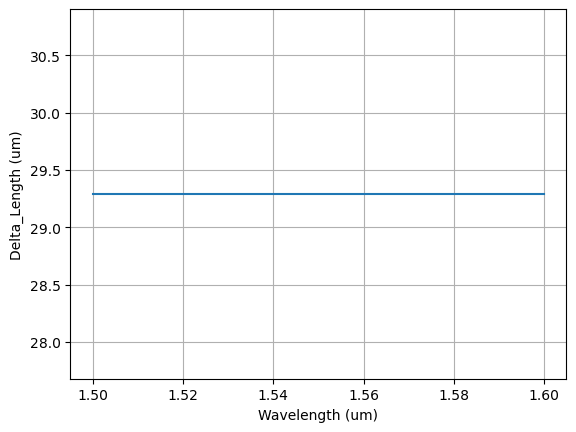

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# Assuming mzi_circuit_2 and optimizer are defined elsewhere

def loss_fn(delta_length, wl):
    S = mzi_circuit_2(
        wl=wl,
        syl={"length": delta_length / 2 + 2},
        straight_9={"length": delta_length / 2 + 2},
    )
    return (abs(S["o1", "o2"]) ** 2).mean()

# Compile the loss function with explicit handling of wl as a dynamic argument
jit_loss_fn = jax.jit(loss_fn, static_argnums=(1,))

# Arrays
wavelength_array = np.linspace(1.5, 1.6, 3)
final_loss_array = []
delta_length_array = []

for opt_wl in wavelength_array:
    cost, pos = optimizer.optimize(lambda dl: jit_loss_fn(dl, opt_wl), iters=1000)
    final_loss_array.append(cost)
    delta_length_array.append(pos)

# Plotting
plt.figure()
plt.plot(wavelength_array, final_loss_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Loss")
plt.grid()

plt.figure()
plt.plot(wavelength_array, delta_length_array)
plt.xlabel("Wavelength (um)")
plt.ylabel("Delta_Length (um)")
plt.grid()
